In [2]:
import refitter as rf
reload(rf)

import ROOT as RT
# RT.gROOT.LoadMacro("~/rootlogon.C")
RT.gStyle.SetOptStat(0)
RT.gStyle.SetPalette(RT.kGreenPink)
import numpy as np

#import pyrapp as pya
#reload(pya)
#app = pya.PyRApp([],args=["-O","plots"])
#app.options.saveas=["root","pdf"]
#def save(obj):
#    app.keep(obj,format=True)
#    app.save(True)

import matplotlib.pyplot as plt
    
import root_pandas as rpd
import pandas as pd

#%matplotlib notebook
%matplotlib inline
#%jsroot on
%jsroot off

Welcome to JupyROOT 6.07/07


In [3]:
inputDir="/eos/user/m/musella/data/mod_dep_005"
fname = inputDir+"/output_InsideAcceptance_125.root"
pfx = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV"

trees = map(lambda x: "genDiphotonDumper/trees/InsideAcceptance_125_13TeV_SigmaMpTTag_%d" %x, xrange(3))
gtree = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV_NoTag_0"

genBranches = ["genPt","genRapidity",
            "genJet2p5Pt0","genJet2p5Rapidity0",
            "genJet2p5Pt1","genJet2p5Rapidity1",
            "genJet2p5Pt2","genJet2p5Rapidity3",
            "genJet2p5Pt2","genJet2p5Rapidity3",
            "weight",
            "genNjets2p5","recoNjets2p5"
           ]
recoBranches = ['recoPt','recoRapidity']

dfs = [rpd.read_root(fname,gtree,columns=genBranches)]+map(lambda x: 
                                                           rpd.read_root(fname,x,columns=genBranches+recoBranches), trees )

In [4]:
def setclass_and_weight(x):
    cls,df = x
    cls -= 1
    
    df['class'] = np.full(df.index.size,cls,dtype=np.int8)

    df['absweight'] = np.abs(df['weight'])
    df.weight_column = df['absweight'] 

map(setclass_and_weight,enumerate(dfs))

df = pd.concat(dfs)

In [5]:
X,y,w = df[['genPt','genRapidity']],df[['class']],df['absweight']



In [6]:
from sklearn import ensemble
from sklearn import cross_validation

In [7]:
X_train, X_test, y_train, y_test, w_train, w_test = cross_validation.train_test_split(X,y,w)

In [8]:
clf = ensemble.GradientBoostingClassifier(verbose=1,max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-3,warm_start=True)

In [9]:
clf

GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.001, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=True)

In [10]:
clf.fit(X_train[:100000], y_train[:100000],w_train[:100000])
#clf.fit(X_train, y_train,w_train)

GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.001, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=True)

      Iter       Train Loss   Remaining Time 
         1      165181.8780           34.43s
         2      166318.0797           34.11s
         3      167414.6498           33.92s
         4      168473.0527           33.53s
         5      169430.1544           32.81s
         6      170298.7924           32.30s
         7      171005.7071           31.83s
         8      171659.7248           31.42s
         9      172248.9273           31.79s
        10      172730.2131           32.26s
        20      175077.6889           27.33s
        30      175574.1668           23.55s
        40      175791.9926           19.80s
        50      175945.7144           16.36s
        60      176066.6383           12.90s
        70      176154.3854            9.57s
        80      176251.5718            6.32s
        90      176335.3763            3.13s
       100      176435.9886            0.00s


/cvmfs/sft.cern.ch/lcg/views/LCG_85swan3/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
y_predict = clf.predict(X_test)
y_predict_proba = clf.predict_proba(X_test)

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [14]:
# help(df)

# cm = confusion_matrix(y_test,y_predict)#,sample_weight=w_test)

In [15]:
nevts = np.array(map(lambda x: float(x.index.size), dfs))
nevts

sumw = np.array(map(lambda x: float(x['weight'].sum()), dfs))
sumw

sumaw = np.array(map(lambda x: float(x['absweight'].sum()), dfs))
sumaw

array([ 52.85478273,  18.28185768,  22.26703505,  36.96963906])

In [16]:
nevts / nevts.sum()

array([ 0.40175572,  0.14324487,  0.17232713,  0.28267228])

In [17]:
sumw / sumw.sum()

array([ 0.4066704 ,  0.13786606,  0.17104098,  0.28442256])

In [18]:
sumaw / sumaw.sum()

array([ 0.40541105,  0.14022699,  0.17079442,  0.28356753])

In [19]:
y_predict_proba

array([[ 0.46735607,  0.0011407 ,  0.00274387,  0.52875936],
       [ 0.41895096,  0.02188396,  0.2832517 ,  0.27591338],
       [ 0.51596879,  0.00082401,  0.00232391,  0.48088329],
       ..., 
       [ 0.28343111,  0.40203519,  0.23998312,  0.07455058],
       [ 0.46361303,  0.00123525,  0.00695831,  0.52819341],
       [ 0.2293505 ,  0.55466706,  0.13767877,  0.07830367]])

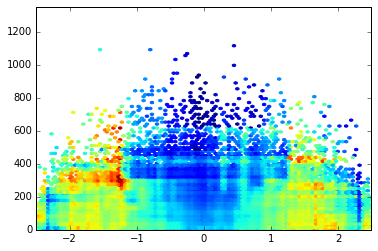

In [20]:
plt.figure()
plt.hexbin(x=X_test['genRapidity'],y=X_test['genPt'],C=y_predict_proba[:,0])
plt.show()

In [21]:
ptmax  = 300.
npt = 300
ptstep = ptmax/npt
pt0 = 0.5*ptstep

rapmax = 3.
nrap = 300
rapstep = rapmax/nrap
rap0 = 0.5*rapstep


ptbinsc = np.arange(pt0,ptmax,ptstep)
rapbinsc = np.arange(rap0,rapmax,rapstep)


In [22]:
import itertools

grid = np.array(list(itertools.product(ptbinsc,rapbinsc)))

In [23]:
predict_grid = clf.predict_proba(grid)
sel_eff = map(np.sum, predict_grid[:,1:])

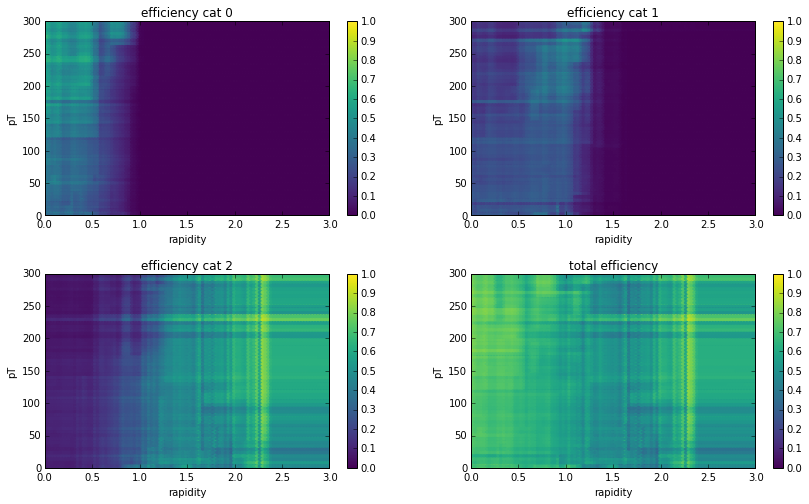

In [24]:
plt.figure(figsize=(14,8))

cmap=cmap=plt.cm.viridis

for iclass in xrange(3):
    plt.subplot(2, 2, iclass+1)

    plt.hexbin(y=grid[:,0],x=grid[:,1],C=predict_grid[:,iclass+1],cmap=cmap,vmin=0,vmax=1)
    plt.ylabel("pT")
    plt.xlabel("rapidity")
    plt.title("efficiency cat %d" % iclass)
    plt.colorbar()
    #plt.colorbar()

plt.subplot(2, 2, 4)
plt.hexbin(y=grid[:,0],x=grid[:,1],C=sel_eff,cmap=cmap,vmin=0,vmax=1)
plt.ylabel("pT")
plt.xlabel("rapidity")
plt.title("total efficiency")
plt.subplots_adjust(hspace=0.3)

plt.colorbar()
plt.show()
plt.savefig("plots/gbr_eff.pdf")

In [25]:
import pickle

In [26]:
s = pickle.dumps(clf)

In [27]:
from gzip import open as gopen
with gopen('gbr_class.pkl.gz','w+') as fout:
    fout.write(s)
    fout.close()

In [29]:
with gopen('gbr_class.pkl.gz') as fin:
    clf2 = pickle.load(fin)

In [30]:
predict_grid2 = clf2.predict_proba(grid)

In [31]:
(predict_grid-predict_grid2).sum()

0.0

In [31]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [32]:
params_grid = { "max_depth" : [3,5,7],
                "learning_rate" : [0.02, 0.1, 0.2],
                "n_estimators" : [100,200,500,1000],
                "min_weight_fraction_leaf" : [ 1e-3, 1e-2, 1e-1]
              }

In [33]:
gclf = RandomizedSearchCV(ensemble.GradientBoostingClassifier(),params_grid,cv=5)

In [34]:
gclf.fit(X_train[:100000], y_train[:100000]['class'])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 500, 1000], 'learning_rate': [0.02, 0.1, 0.2], 'min_weight_fraction_leaf': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [35]:
print("Best parameters set found on development set:")
print()
print(gclf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in gclf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

Best parameters set found on development set:
()
{'n_estimators': 100, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.01, 'max_depth': 5}
()
Grid scores on development set:
()
0.422 (+/-0.006) for {'n_estimators': 100, 'learning_rate': 0.1, 'min_weight_fraction_leaf': 0.1, 'max_depth': 5}
0.425 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.01, 'max_depth': 5}
0.410 (+/-0.004) for {'n_estimators': 500, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.001, 'max_depth': 5}
0.423 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.001, 'max_depth': 3}
0.421 (+/-0.006) for {'n_estimators': 200, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.1, 'max_depth': 3}
0.423 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.01, 'max_depth': 3}
0.420 (+/-0.006) for {'n_estimators': 100, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.001, 'max_depth': 5}
0.419 (+/-

In [36]:
gclf.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_weight_fraction_leaf': 0.01,
 'n_estimators': 100}

In [37]:
gclf.grid_scores_

[mean: 0.42196, std: 0.00307, params: {'n_estimators': 100, 'learning_rate': 0.1, 'min_weight_fraction_leaf': 0.1, 'max_depth': 5},
 mean: 0.42505, std: 0.00211, params: {'n_estimators': 100, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.01, 'max_depth': 5},
 mean: 0.41032, std: 0.00177, params: {'n_estimators': 500, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.001, 'max_depth': 5},
 mean: 0.42331, std: 0.00215, params: {'n_estimators': 100, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.001, 'max_depth': 3},
 mean: 0.42083, std: 0.00286, params: {'n_estimators': 200, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.1, 'max_depth': 3},
 mean: 0.42328, std: 0.00195, params: {'n_estimators': 100, 'learning_rate': 0.02, 'min_weight_fraction_leaf': 0.01, 'max_depth': 3},
 mean: 0.42027, std: 0.00284, params: {'n_estimators': 100, 'learning_rate': 0.2, 'min_weight_fraction_leaf': 0.001, 'max_depth': 5},
 mean: 0.41928, std: 0.00184, params: {'n_estimators': 1000, 'lea

In [38]:
clfo = ensemble.GradientBoostingClassifier(verbose=1,**gclf.best_params_)

In [39]:
clfo.fit(X_train[:100000], y_train[:100000]['class'],w_train[:100000])

GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

      Iter       Train Loss   Remaining Time 
         1      165170.0399           32.19s
         2      166254.2376           32.02s
         3      167335.9873           31.71s
         4      168374.2454           31.34s
         5      169330.7630           31.05s
         6      170193.6353           30.70s
         7      170966.1995           30.38s
         8      171644.2674           30.02s
         9      172233.3665           29.72s
        10      172727.5325           29.43s
        20      175122.3280           25.79s
        30      175651.1550           22.02s
        40      175810.6772           18.55s
        50      175907.6338           15.24s
        60      175956.7578           12.04s
        70      176031.9090            8.97s
        80      176137.9438            5.95s
        90      176202.8018            2.97s
       100      176239.1574            0.00s


In [32]:
clfo = clf
predict_grido = clfo.predict_proba(grid)
sel_effo = map(np.sum, predict_grido[:,1:])

In [33]:
predict_diff = (predict_grido- predict_grid)/predict_grid

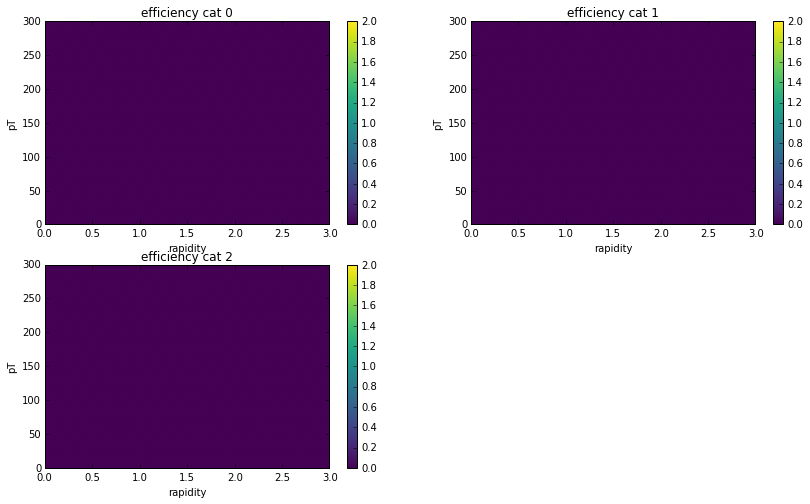

In [34]:
plt.figure(figsize=(14,8))

for iclass in xrange(3):
    plt.subplot(2, 2, iclass+1)

    plt.hexbin(y=grid[:,0],x=grid[:,1],C=np.abs(predict_diff[:,iclass+1]),cmap=cmap,vmin=0,vmax=2)
    plt.ylabel("pT")
    plt.xlabel("rapidity")
    plt.title("efficiency cat %d" % iclass)
    plt.colorbar()
    #plt.colorbar()
    

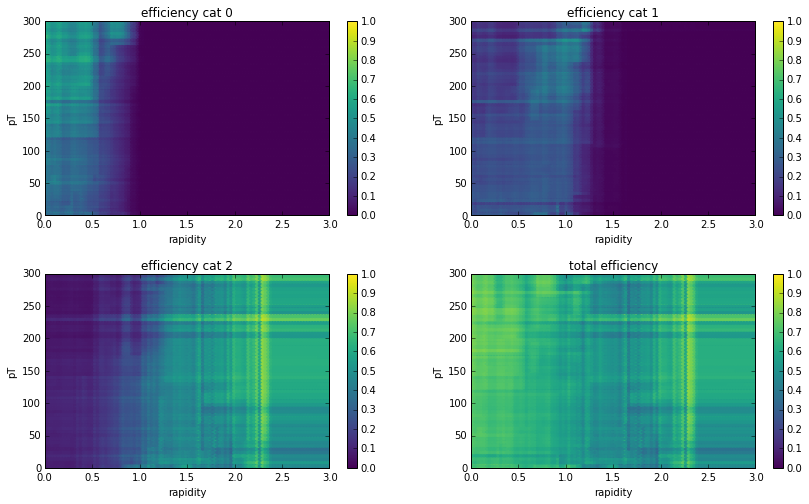

In [35]:
plt.figure(figsize=(14,8))

cmap=cmap=plt.cm.viridis

for iclass in xrange(3):
    plt.subplot(2, 2, iclass+1)

    plt.hexbin(y=grid[:,0],x=grid[:,1],C=predict_grido[:,iclass+1],cmap=cmap,vmin=0,vmax=1)
    plt.ylabel("pT")
    plt.xlabel("rapidity")
    plt.title("efficiency cat %d" % iclass)
    plt.colorbar()
    #plt.colorbar()

plt.subplot(2, 2, 4)
plt.hexbin(y=grid[:,0],x=grid[:,1],C=sel_effo,cmap=cmap,vmin=0,vmax=1)
plt.ylabel("pT")
plt.xlabel("rapidity")
plt.title("total efficiency")
plt.subplots_adjust(hspace=0.3)

plt.colorbar()
#plt.show()
plt.savefig("plots/gbr_eff.pdf")

In [36]:

with gopen('gbr_opt.pkl.gz','w+') as fout:
    pickle.dump(clfo,fout)
    fout.close()

In [37]:
#df.to_hdf('inside_acceptance.hd5','all_125')

In [39]:
recoPtBins=[-100,0,15,30,60,120,160,180,200,1000]
recoPtLabels = [-1]+range(len(recoPtBins)-2)

#del df['recoPtBin']

df['recoPtBin'] = pd.cut(df['recoPt'],bins=recoPtBins,labels=recoPtLabels)
#df['recoPtBin'] =df['recoPtBin'].fillna(-1)
df['recoPtBin'].describe()

count     831186
unique         8
top            3
freq      252606
Name: recoPtBin, dtype: int64

In [40]:
sub=df[ df['class'] == -1 ]
#sub['recoPtBin'] = np.full(sub.index.size,-1)
#sub['recoPtBin']=sub['recoPtBin'].fillna(-1)
sub['recoPtBin'].describe()

count     0
unique    0
Name: recoPtBin, dtype: int64

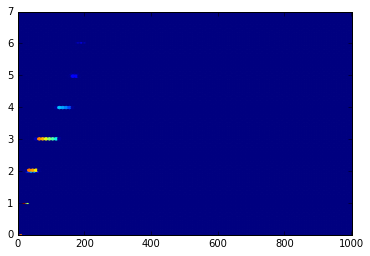

In [41]:
plt.hexbin(x=df['genPt'], y=df['recoPtBin'])
#df['ptcat'] 

In [42]:
df['recoPtCat'] = df['class'] + 3*df['recoPtBin']

In [43]:
df['recoPtCat'] = df['recoPtCat'].fillna(-1)

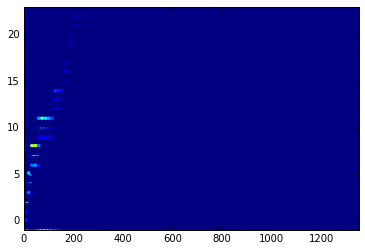

In [44]:
plt.hexbin(x=df['genPt'], y=df['recoPtCat'])
#df['ptcat'] 

In [45]:
class_probs = clfo.predict_proba(df[['genPt','genRapidity']])

In [1]:
clfo

NameError: name 'clfo' is not defined

In [50]:
for icl in range(clf.loss_.K):
    df['class_probs_%d' % icl] = class_probs[:,icl]

In [64]:
X,y = df[['class_probs_0','class_probs_1','class_probs_2','class_probs_3','genPt','genRapidity']],df['recoPtCat']

In [65]:
clfpt = ensemble.GradientBoostingClassifier(verbose=1,max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-3,warm_start=True)

In [66]:
X_train, X_test, y_train, y_test, w_train, w_test = cross_validation.train_test_split(X,y,w)

In [67]:
clfpt.fit(X_train,y_train)

GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.001, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=True)

In [68]:
pt_probs = clfpt.predict_proba(X_train)

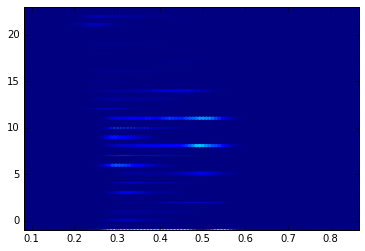

In [74]:
plt.hexbin(y=y_train,x=pt_probs[:,0])